# Fintech name ideas:

## 1. BrokeFund

## 2. PayUpFront

## 3. NoFunds Inc


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
past_loans = pd.read_csv('PastLoans.csv')

In [8]:
past_loans.head()

,sex,employment,married,income,digital1,digital2,digital3,default
0,M,unemployed,0,0,0.749267,0.422656,0.738735,0
1,M,employed,1,26108,0.697428,0.596361,0.733947,0
2,M,employed,1,11810,0.000000,0.652496,0.000000,0
3,M,unemployed,1,0,0.000000,0.000000,0.000000,0
4,F,retired,1,6310,0.000000,0.041123,0.203202,0


In [10]:
past_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   sex         100000 non-null  object 
 1   employment  100000 non-null  object 
 2   married     100000 non-null  int64  
 3   income      100000 non-null  int64  
 4   digital1    100000 non-null  float64
 5   digital2    100000 non-null  float64
 6   digital3    100000 non-null  float64
 7   default     100000 non-null  int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 6.1+ MB


In [11]:
new_applicants = pd.read_csv('NewApplications_Lender2_Round1.csv')

In [12]:
new_applicants.head()

,id,sex,employment,married,income,digital2
0,1,M,employed,0,29758,0.000000
1,2,F,retired,1,6140,0.000000
2,3,F,employed,1,27186,0.008139
3,4,M,employed,1,8429,0.624570
4,5,M,retired,1,2820,0.097230


In [13]:
new_applicants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          100000 non-null  int64  
 1   sex         100000 non-null  object 
 2   employment  100000 non-null  object 
 3   married     100000 non-null  int64  
 4   income      100000 non-null  int64  
 5   digital2    100000 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB


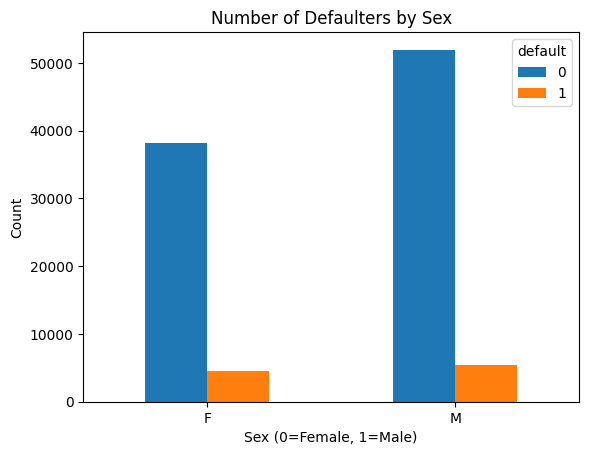

In [14]:
# Group by 'sex' and 'default', and count the occurrences
grouped_data = past_loans.groupby(['sex', 'default']).size().unstack()

# Create the bar plot
grouped_data.plot(kind='bar', stacked=False)

# Add titles and labels
plt.title('Number of Defaulters by Sex')
plt.xlabel('Sex (0=Female, 1=Male)')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Show the plot
plt.show()

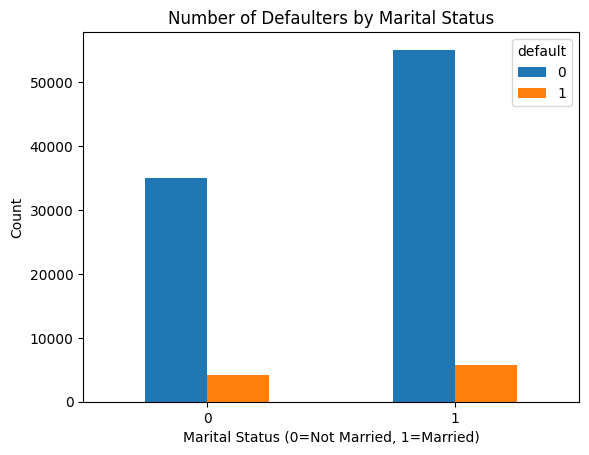

In [15]:
# Group by 'married' and 'default', and count the occurrences
grouped_data2 = past_loans.groupby(['married', 'default']).size().unstack()

# Create the bar plot
grouped_data2.plot(kind='bar', stacked=False)

# Add titles and labels
plt.title('Number of Defaulters by Marital Status')
plt.xlabel('Marital Status (0=Not Married, 1=Married)')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Show the plot
plt.show()

/var/folders/2r/xjzdhv614ll26kt0l39p1gr00000gn/T/ipykernel_36331/59998506.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = past_loans.groupby(['income_bin', 'default']).size().unstack()


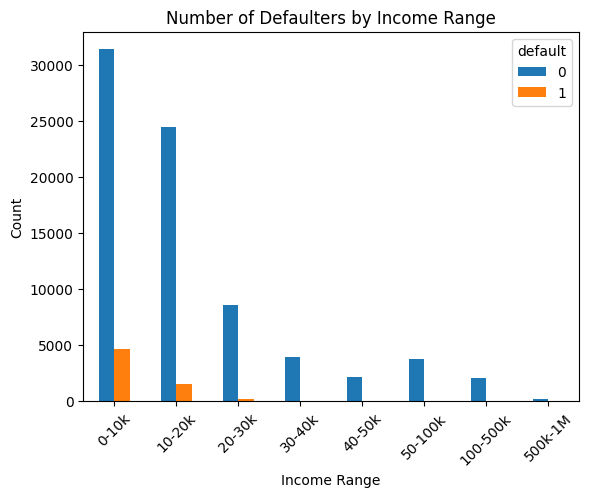

In [17]:
# Define smaller bins for people earning less than 50k, and larger bins for others
bins = [0, 10000, 20000, 30000, 40000, 50000, 100000, 500000, 1000000]
bin_labels = ['0-10k', '10-20k', '20-30k', '30-40k', '40-50k', '50-100k', '100-500k', '500k-1M']

# Create a new column 'income_bin' by binning the 'income' column
past_loans['income_bin'] = pd.cut(past_loans['income'], bins=bins, labels=bin_labels)

# Group by 'income_bin' and 'default', and count the occurrences
grouped_data = past_loans.groupby(['income_bin', 'default']).size().unstack()

# Create the bar plot
grouped_data.plot(kind='bar', stacked=False)

# Add titles and labels
plt.title('Number of Defaulters by Income Range')
plt.xlabel('Income Range')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [21]:
past_loans['default'].value_counts()

default
0    90053
1     9947
Name: count, dtype: int64